In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import seaborn as sns

In [2]:
traindir = 'OCT2017/train'
testdir = 'OCT2017/test'

In [3]:
labels = os.listdir(traindir)
train_datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              zoom_range=0.15,
                                   validation_split=0.2)

In [4]:
IMG_SIZE = 224
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='validation',
    class_mode='categorical')

valid_X, valid_Y = next(validation_generator)

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


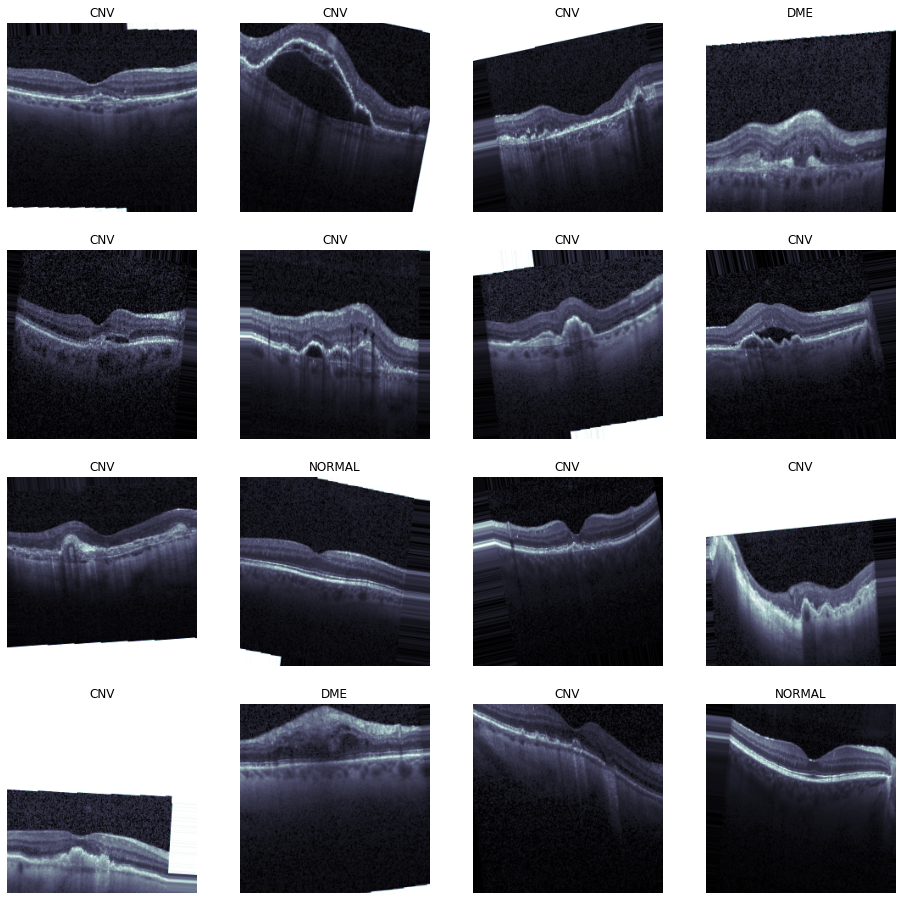

In [5]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

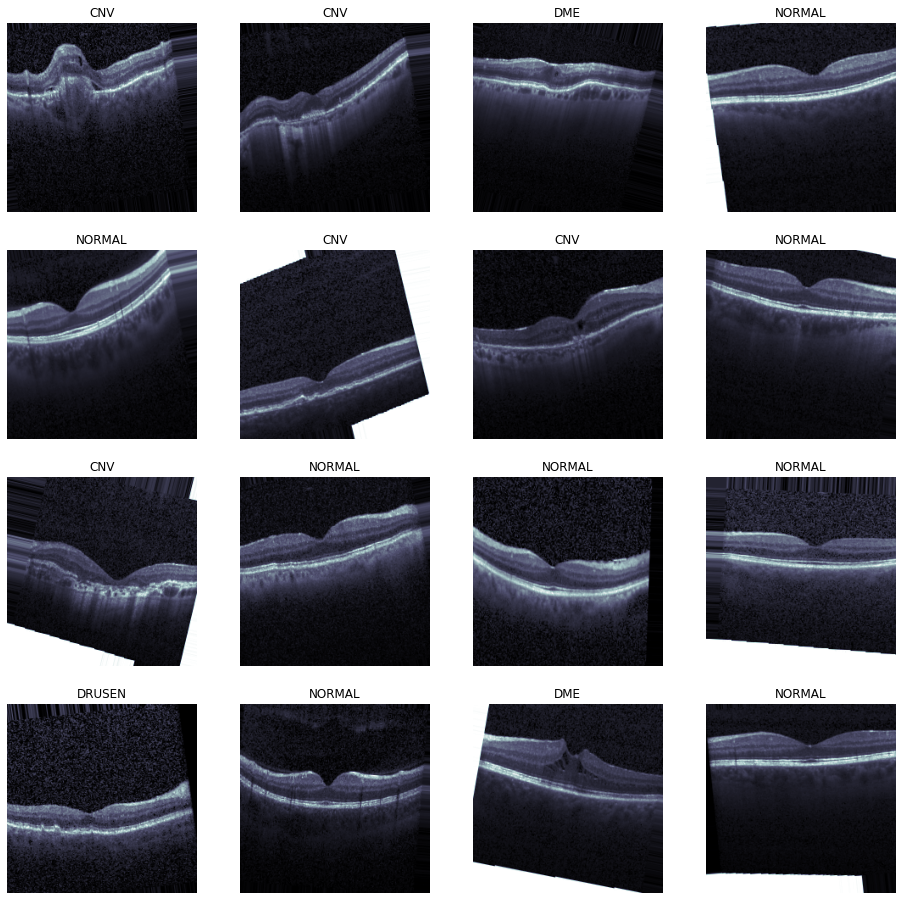

In [6]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [7]:
def densenet_model():
    tx_shape = [224, 224, 3]
    # img_in = Input(t_x.shape[1:]) 
    img_in = Input(tx_shape)              #input of model 
    model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= tx_shape,
                pooling ='avg') 
    x = model.output  
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [8]:
model = densenet_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="DenseNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3,verbose = 1,restore_best_weights = True)
callbacks_list = [checkpoint]

In [11]:
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=500,
                                  validation_data = (valid_X,valid_Y),
                                  epochs = 30,
                                  callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
500/500 [==============================] - 5420s 11s/step - loss: 0.4870 - accuracy: 0.8292 - val_loss: 2.7886 - val_accuracy: 0.5625
Epoch 2/30
500/500 [==============================] - 5107s 10s/step - loss: 0.3187 - accuracy: 0.8940 - val_loss: 0.6380 - val_accuracy: 0.9375
Epoch 3/30
500/500 [==============================] - 5126s 10s/step - loss: 0.2960 - accuracy: 0.9016 - val_loss: 0.3989 - val_accuracy: 0.8125
Epoch 4/30
500/500 [==============================] - 4933s 10s/step - loss: 0.2749 - accuracy: 0.9081 - val_loss: 0.4191 - val_accuracy: 0.8750
Epoch 5/30
500/500 [==============================] - 4941s 10s/step - loss: 0.2597 - accuracy: 0.9110 - val_loss: 0.3187 - val_accuracy: 0.8750
Epoch 6/30
500/500 [==============================] - 4885s 10s/step - loss: 0.2587 - accuracy: 0.9146 - val_loss: 0.3508 - val_accuracy: 0.8750
Epoch 7/30
500/500 [==============================] - 

Epoch 27/30
500/500 [==============================] - 4807s 10s/step - loss: 0.1524 - accuracy: 0.9496 - val_loss: 0.1005 - val_accuracy: 0.9375
Epoch 28/30
500/500 [==============================] - 4840s 10s/step - loss: 0.1518 - accuracy: 0.9490 - val_loss: 0.0685 - val_accuracy: 1.0000
Epoch 29/30
500/500 [==============================] - 4818s 10s/step - loss: 0.1592 - accuracy: 0.9489 - val_loss: 0.0831 - val_accuracy: 0.9375
Epoch 30/30
500/500 [==============================] - 4821s 10s/step - loss: 0.1591 - accuracy: 0.9463 - val_loss: 0.1770 - val_accuracy: 0.9375


In [12]:
test_X, test_Y = next(train_datagen.flow_from_directory(testdir,target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=968,
                                                  class_mode='categorical',
                                                  shuffle = False))

Found 968 images belonging to 4 classes.


In [13]:
y_pred = model.predict(test_X)

In [14]:
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

In [15]:
actual_class = []
for i in range(len(test_Y)):
    actual_class.append(np.argmax(test_Y[i]))

In [16]:
print(' Test accuracy = ',accuracy_score(pred_class,actual_class))

 Test accuracy =  0.9896694214876033


In [17]:
print ('Train Accuracy', np.mean(history.history['accuracy']))
print ('Train Loss', np.mean(history.history['loss']))
print ('Validation Accuracy', np.mean(history.history['val_accuracy']))
print ('Validation Loss', np.mean(history.history['val_loss']))

Train Accuracy 0.9292267183462779
Train Loss 0.21206213037172952
Validation Accuracy 0.9104166666666667
Validation Loss 0.30720316333075365


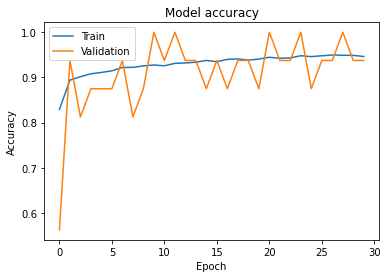

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


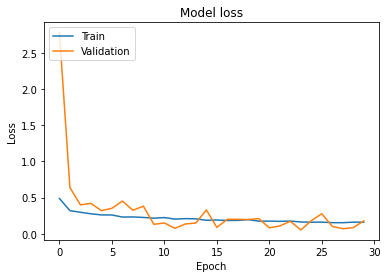

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = ['CNV','DME','DRUSEN','NORMAL']
    sns.set(font_scale=1.2)
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="BuPu", fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    return C

-------------------- Confusion matrix --------------------


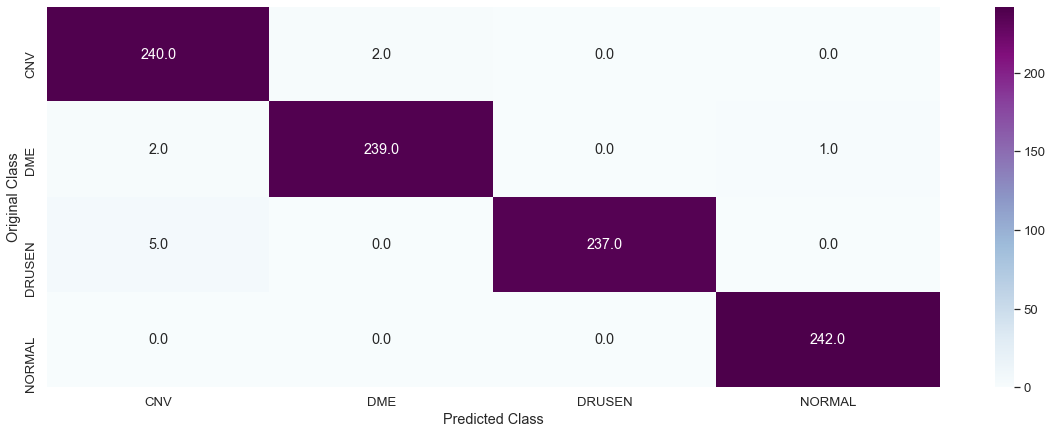

In [22]:
cm = plot_confusion_matrix(actual_class,pred_class)

In [23]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall/TPR = {}".format(TPR))

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity/TNR = {}".format(TNR))

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision/PPV = {}".format(PPV))

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predict Value = {}".format(NPV))

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate = {}".format(FPR))

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate = {}".format(FNR))

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate = {}".format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy = {}".format(ACC))

Recall/TPR = [0.99173554 0.98760331 0.97933884 1.        ]
Specificity/TNR = [0.99035813 0.99724518 1.         0.99862259]
Precision/PPV = [0.97165992 0.99170124 1.         0.99588477]
Negative Predict Value = [0.99722607 0.99587345 0.99316005 1.        ]
False Positive Rate = [0.00964187 0.00275482 0.         0.00137741]
False Negative Rate = [0.00826446 0.01239669 0.02066116 0.        ]
False discovery rate = [0.02834008 0.00829876 0.         0.00411523]
Overall Accuracy = [0.99070248 0.99483471 0.99483471 0.99896694]
